# 1) Ferro BTC

## a) Ferro_backtest.csv

In [27]:
# read .xlsx file from downloads folderL 
import pandas as pd
df = pd.read_excel('./PNL/Performance_Dubai_BTCUSD.xlsx', sheet_name='Sheet1')
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date", drop=False)

In [28]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT"]
timeframes = ["1d"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2023-01-01 00:00:00",
                                        limit = 1000, update=False)


Getting <<BTC-USDT>> from <<kucoin>> 
BTC-USDT (1d)


In [29]:
df =pd.merge(df, klines_dict["ccxt_kucoin__BTC-USDT"]["1d"][["close","volume"]], left_index=True, right_index=True, how="left")
df

,Date,PV,close,volume
Date,,,,
2023-04-24,2023-04-24,400146.75,27506.0,4616.001503
2023-04-25,2023-04-25,400209.24,28297.0,4577.010334
2023-04-26,2023-04-26,400397.08,28415.1,9392.808779
2023-04-27,2023-04-27,397767.00,29473.9,7447.575043
2023-04-28,2023-04-28,400000.31,29309.9,4842.034658
...,...,...,...,...
2023-09-18,2023-09-18,423483.36,26764.1,3299.246038
2023-09-19,2023-09-19,420423.90,27204.2,3083.837233
2023-09-20,2023-09-20,413148.65,27120.2,2540.666833


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def calculate_metrics(df0):
    # Ensure the Date column is in datetime format
    df=df0.copy()
    # Calculate daily returns
    df['Return'] = df['PV'].pct_change()
    
    # Calculate annualized return
    annualized_return = np.prod(1 + df['Return']) ** (252/len(df)) - 1
    
    # Calculate annualized standard deviation
    annualized_std_dev = df['Return'].std() * np.sqrt(252)
    
    # Calculate Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_std_dev
    
    # Calculate maximum drawdown
    df['Cumulative Return'] = (1 + df['Return']).cumprod()
    df['Cumulative Roll Max'] = df['Cumulative Return'].cummax()
    df['Drawdown'] = df['Cumulative Roll Max'] - df['Cumulative Return']
    max_drawdown = df['Drawdown'].max()
    
    # Calculate Calmar ratio
    calmar_ratio = annualized_return / max_drawdown
    
    metrics = {'Annualized Return': f"{round(annualized_return*100, 2)} %",
               'Annualized Std Dev': f"{round(annualized_std_dev*100, 2)} %",
               'Sharpe Ratio': round(sharpe_ratio, 2),
               'Max Drawdown': f"{round(max_drawdown*100, 2)} %",
               'Calmar Ratio': round(calmar_ratio, 2)}
    
    # Plotting
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2, 1.5, 1]})
    
    ax[0].axis('tight')
    ax[0].axis('off')
    ax[0].table(cellText=[list(metrics.values())], colLabels=list(metrics.keys()), cellLoc='center', loc='center')
    
    ax[1].plot(df.index, df['PV'], label='PV')
    ax1_twin = ax[1].twinx()
    ax1_twin.plot(df.index, df['close'], color='black', label='Close', alpha=0.3)
    ax[1].set_title('Portfolio Value Over Time (blue) vs underlying price (black)')
    
    ax[2].fill_between(df.index, df['Drawdown']*100, color='red')
    ax[2].set_title('Drawdown Over Time (%)')
    ax[2].invert_yaxis()
    
    plt.tight_layout()
    

    # Calculate monthly returns and display as a table below the drawdown plot
    df_m = pd.DataFrame()
    monthly_returns = df.resample('M')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    # Round to 2 dp
    monthly_returns = monthly_returns.round(2)
    df_m["Month Return"] = monthly_returns
    # monthly_returns = df1.resample('M')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    

    
    ax[3].axis('tight')
    ax[3].axis('off')
    
    # cell_text = [[f"{v*100:.2f} %" if pd.notnull(v) else "" for v in monthly_returns.values]] # Reshape to a 2D l}ist and convert to percentage string
    # ax[3].table(cellText=cell_text, rowLabels=[], colLabels=monthly_returns.index.strftime('%Y-%m'), cellLoc='center', loc='center')
    df_m['Month'] = df_m.index.month
    df_m['Year'] = df_m.index.year 
    

    # Pivot the table 
    df_pivot = df_m.pivot(index='Year', columns='Month')

    # Now we can plot the table
    index_months = {0:"Jan", 1:"Feb", 2:"Mar", 3:"Apr", 4:"May", 5:"Jun", 
                6:"Jul", 7:"Aug", 8:"Sep", 9:"Oct", 10:"Nov", 11:"Dec"}
    print(df_pivot)
    cell_text = df_pivot.values.tolist() # Convert DataFrame values to a 2D list
    ax[3].table(cellText=cell_text, rowLabels=df_pivot.index, colLabels=df_pivot.columns, cellLoc='center', loc='center')


    print(f"\n\n\ndf_pivot:\n{df_pivot}")
    return df_pivot



      Month Return                              
Month            4     5     6     7     8     9
Year                                            
2023           NaN  1.13 -0.41  5.64 -0.41  0.85



df_pivot:
      Month Return                              
Month            4     5     6     7     8     9
Year                                            
2023           NaN  1.13 -0.41  5.64 -0.41  0.85


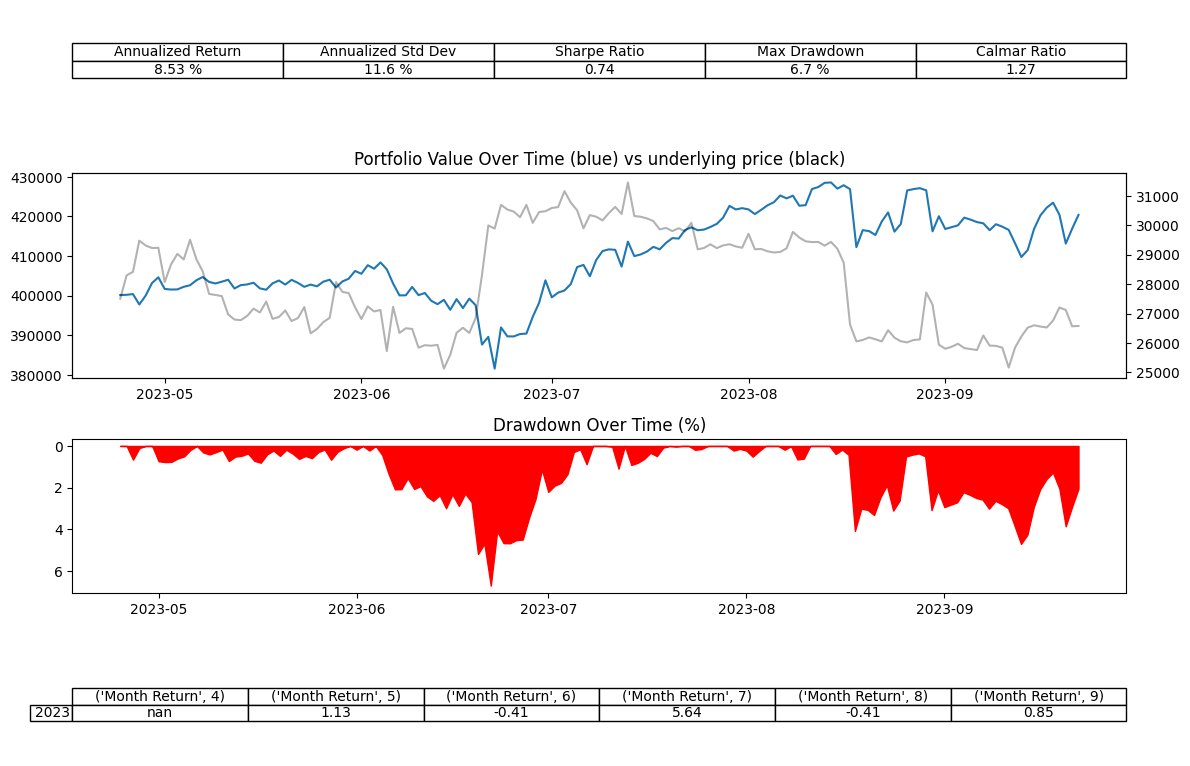

In [31]:
df_res = calculate_metrics(df)

## b) Performance_Dubai_BTCUSD.xlsx

In [34]:
# read .xlsx file from downloads folderL 
import pandas as pd
df = pd.read_csv('./PNL/Ferro_backtest.csv')
df["Date"] = pd.to_datetime(df["timestamp"])
df = df.set_index("Date", drop=False)
df.drop(columns=["Unnamed: 0"], inplace=True)

In [20]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT"]
timeframes = ["1d"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2020-01-01 00:00:00",
                                        limit = 1000, update=True)


Getting <<BTC-USDT>> from <<kucoin>> 
BTC-USDT (1d)
Requested (2020-01-01 00:00:00) < available (2021-01-03 00:00:00) ---> Querying from 2020-01-01 00:00:00
--> in database (1000 rows): 2021-01-03 00:00:00 ===> 2020-01-01 00:00:00 (0.0s)
BTC-USDT fetched: 2021-01-03T00:00:00.000Z to 2023-09-29T00:00:00.000Z
---> 1000 | 2023-09-29T00:00:00.000Z to 2021-01-03T00:00:00.000Z
BTC-USDT fetched: 2018-04-09T00:00:00.000Z to 2021-01-02T00:00:00.000Z
---> 2000 | 2021-01-02T00:00:00.000Z to 2021-01-03T00:00:00.000Z
--> queried     (2000 rows): 2018-04-09 00:00:00 ===> 2023-09-29 00:00:00 (3.91s)
--> updated     (2000 rows): 2018-04-09 00:00:00 ===> 2023-09-29 00:00:00 (0.0s)


In [35]:
klines_dict["ccxt_kucoin__BTC-USDT"]["1d"]

,open,high,low,close,volume,close_time
datetime,,,,,,
2018-04-09,6999.990000,7199.000000,6620.000000,6767.883158,216.925211,1.523232e+09
2018-04-10,6772.936980,6911.564621,6666.000001,6840.000000,106.477898,1.523318e+09
2018-04-11,6840.000000,6995.000000,6781.000000,6965.178929,120.154393,1.523405e+09
2018-04-12,6965.178929,7986.000000,6752.906434,7933.915324,398.755611,1.523491e+09
2018-04-13,7933.915324,8234.130556,7718.000000,7863.192100,336.644543,1.523578e+09
...,...,...,...,...,...,...
2023-09-25,26248.800000,26448.300000,26000.000000,26300.900000,1638.323017,1.695600e+09
2023-09-26,26301.000000,26395.000000,26092.300000,26221.300000,1487.506924,1.695686e+09
2023-09-27,26221.400000,26849.000000,26114.000000,26368.800000,2799.763603,1.695773e+09


In [36]:
df =pd.merge(df, klines_dict["ccxt_kucoin__BTC-USDT"]["1d"][["close","volume"]], left_index=True, right_index=True, how="left")
df

,timestamp,T1xD1 (BTC),T1xD2 (BTC),T1xD3 (BTC),T2xD1 (BTC),T2xD2 (BTC),T2xD3 (BTC),T3xD1 (BTC),T3xD2 (BTC),T3xD3 (BTC),...,Return(T2xD1 (BTC)),Return(T2xD2 (BTC)),Return(T2xD3 (BTC)),Return(T3xD1 (BTC)),Return(T3xD2 (BTC)),Return(T3xD3 (BTC)),Total,Cumulative,close,volume
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,2021-01-02 00:00:00,0.000055,-0.000002,0.000036,0.000042,0.000011,0.000014,0.000002,-0.000004,-0.000009,...,0.0,0.0,0.000000,0.000000,-0.0,-0.0,0.000000,1.000000,32185.4,5165.023459
2021-01-03,2021-01-03 00:00:00,-0.003686,-0.004585,-0.004965,-0.001420,-0.001865,-0.001950,-0.000357,-0.000643,-0.000746,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,0.000000,1.000000,33000.4,5674.961437
2021-01-04,2021-01-04 00:00:00,-0.001579,-0.003108,-0.003549,-0.000737,-0.001857,-0.002430,-0.000446,-0.000736,-0.000959,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,0.000000,1.000000,31993.0,7405.232853
2021-01-05,2021-01-05 00:00:00,-0.000302,-0.000760,-0.000916,-0.000372,-0.000617,-0.000752,-0.000586,-0.000780,-0.000953,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,0.000000,1.000000,33938.6,5222.379905
2021-01-06,2021-01-06 00:00:00,-0.000481,-0.000824,-0.001277,-0.000482,-0.000388,-0.000440,0.000044,-0.000004,0.000055,...,-0.0,-0.0,-0.000000,0.000000,-0.0,0.0,0.000000,1.000000,36750.6,5514.164553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-04,2023-09-04 00:00:00,0.000085,-0.000077,-0.000115,0.000021,-0.000026,-0.000098,0.000038,0.000016,-0.000203,...,0.0,-0.0,-0.000098,0.000038,0.0,-0.0,0.000025,3.256156,25826.7,2170.377151
2023-09-05,2023-09-05 00:00:00,0.000282,0.000404,0.000672,0.000156,0.000387,0.000642,0.000118,0.000304,0.000472,...,0.0,0.0,0.000642,0.000118,0.0,0.0,0.001042,3.259548,25792.4,1832.562034
2023-09-06,2023-09-06 00:00:00,0.000114,0.000222,0.000436,-0.000002,0.000018,0.000112,-0.000026,-0.000082,-0.000144,...,-0.0,0.0,0.000112,-0.000026,-0.0,-0.0,0.000200,3.260199,25759.5,2189.084221


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def calculate_metrics(df0, N=365):
    # Ensure the Date column is in datetime format
    df=df0.copy()
    # Calculate daily returns from cumulative
    returns = df["Cumulative"]
    total_years = len(returns) / N  # Assuming 252 trading days in a year

    # Calculate annualized return
    annualized_return = (returns.iloc[-1] / returns.iloc[0]) ** (1/total_years) - 1
    daily_returns = returns.pct_change().dropna()

    # Calculate annualized standard deviation
    annualized_std_dev = np.sqrt(N) * daily_returns.std()
    
    # Calculate Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_std_dev
    
    # Calculate maximum drawdown
    df['Cumulative Return'] = (1 + daily_returns).cumprod()
    df['Cumulative Roll Max'] = df['Cumulative'].cummax()
    df['Drawdown'] = df['Cumulative Roll Max'] - df['Cumulative']
    max_drawdown = df['Drawdown'].max()
    
    # Calculate Calmar ratio
    calmar_ratio = annualized_return / max_drawdown
    
    metrics = {'Annualized Return': f"{round(annualized_return*100, 2)} %",
               'Annualized Std Dev': f"{round(annualized_std_dev*100, 2)} %",
               'Sharpe Ratio': round(sharpe_ratio, 2),
               'Max Drawdown': f"{round(max_drawdown*100, 2)} %",
               'Calmar Ratio': round(calmar_ratio, 2)}
    
    # ============================================================================================
    # Plotting
    # ============================================================================================
    
    # -----------------------
    # 0) Initialise subplots
    # -----------------------
    fig, ax = plt.subplots(4, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 2, 1.5, 1]})
    years = df.index.year.unique()

    # -----------------------
    # 1) Metrics table 
    # -----------------------
    ax[0].axis('tight')
    ax[0].axis('off')
    ax[0].table(cellText=[list(metrics.values())], colLabels=list(metrics.keys()), cellLoc='center', loc='center')
    
    # -----------------------
    # 2) Portfolio value vs underlying price
    # -----------------------
    ax[1].plot(df.index, df['Cumulative']*100, label='Cumulative')
    ax1_twin = ax[1].twinx()
    ax1_twin.plot(df.index, df['close'], color='black', label='Close', alpha=0.3)
    ax1_twin.set_ylabel("Price")
    ax[1].set_ylabel("Cumulative %")
    ax[1].set_title('Cumulative % Over Time (blue) vs underlying price (black)')
    ax[1].grid(True)
    # for year in years:
    #     ax[1].axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.5)


    # -----------------------
    # 3) Drawdown plot
    # -----------------------
    ax[2].fill_between(df.index, df['Drawdown']*100, color='red')
    ax[2].set_title('Drawdown Over Time (%)')
    ax[2].invert_yaxis()
    ax[2].grid(True)
    # for year in years:
    #     ax[2].axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.5)
    
    # -----------------------
    # 4) Monthly returns table
    # -----------------------
    ax[3].set_title("Monthly Returns (%)")
    ax[3].axis('tight')
    ax[3].axis('off')

    df_m = pd.DataFrame()
    monthly_returns = df.resample('M')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    monthly_returns = monthly_returns.round(2)
    df_m["Month Return"] = monthly_returns
    df_m['Month'] = df_m.index.month
    df_m['Year'] = df_m.index.year 

    # Pivot the table 
    df_pivot = df_m.pivot(index='Year', columns='Month')

    # Correct the index_months dictionary to start from 1
    index_months = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
                7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

    # Replace the column names using the index_months dictionary
    df_pivot.columns = [(col[0], index_months[col[1]]) for col in df_pivot.columns]

    # Now we can plot the table
    cell_text = df_pivot.values.tolist() # Convert DataFrame values to a 2D list

    # Replace NaN values with '-'
    cell_text = [['-' if pd.isnull(val) else val for val in row] for row in cell_text]

    # Calculate yearly returns and add them to the cell text
    df_cum = df[['Cumulative Return']].copy().dropna()
    yearly_returns = df_cum.resample('Y')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100
    print(yearly_returns)
    yearly_returns = yearly_returns.round(2)
    for i in range(len(df_pivot.index)):
        cell_text[i].append(yearly_returns[i])

    # Add 'Yearly Return' to the column labels
    col_labels = [col[1] for col in df_pivot.columns] + ['Yearly Return']

    # Create a table and get its cells
    table = ax[3].table(cellText=cell_text, rowLabels=df_pivot.index, colLabels=col_labels, cellLoc='center', loc='center')
    cells = table.get_celld()

    # Iterate over the cells of the table and change their color based on the value of the monthly return
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns) + 1):  # +1 because we added a column
            if cell_text[i][j] != '-' and cell_text[i][j] > 0:
                cells[(i+1, j)].set_facecolor('lightgreen')
            elif cell_text[i][j] != '-' and cell_text[i][j] <= 0:
                cells[(i+1, j)].set_facecolor('lightcoral')
    

    # -----------------------
    # Final touches
    # -----------------------
    fig.suptitle("Performance_Dubai_BTCUSD", fontsize=20)
    plt.tight_layout()

    
    return df



Date
2021-12-31    129.026373
2022-12-31     23.552646
2023-12-31     14.999831
Freq: A-DEC, Name: Cumulative Return, dtype: float64


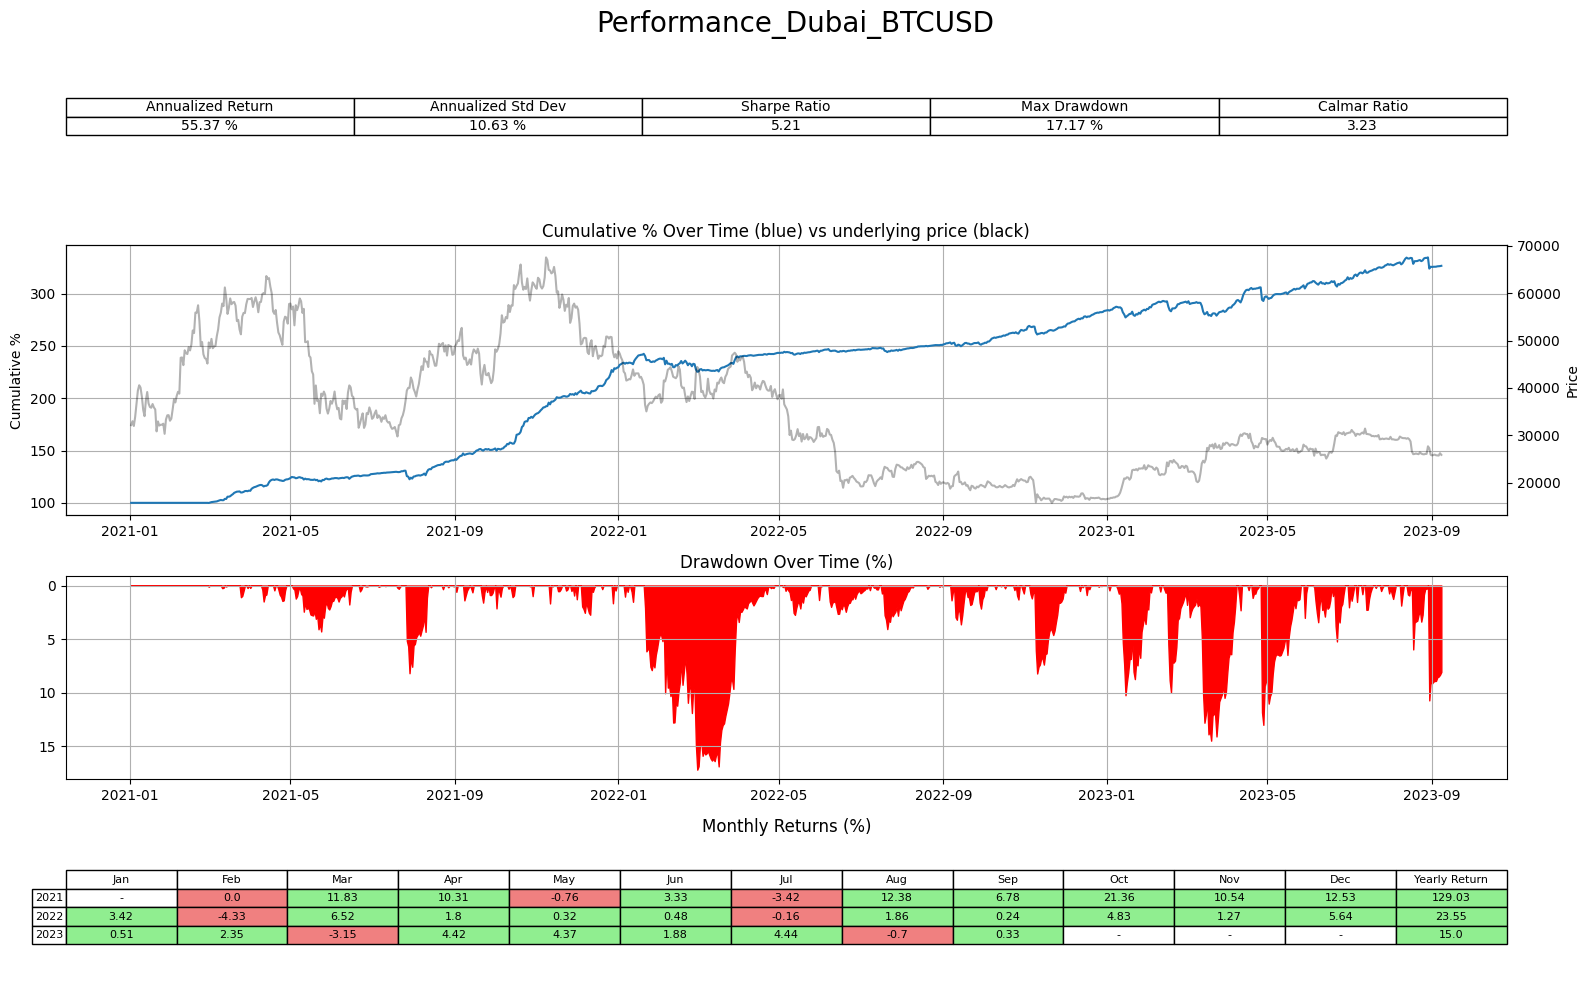

In [110]:
df_res = calculate_metrics(df)

In [101]:
df_res.dropna().resample('Y')['Cumulative Return'].apply(lambda x: x[-1] / x[0] - 1)*100

Date
2021-12-31    129.026373
2022-12-31     23.552646
2023-12-31     14.999831
Freq: A-DEC, Name: Cumulative Return, dtype: float64

In [98]:
df_res.resample('Y')["Cumulative Return"].head(1)

,timestamp,T1xD1 (BTC),T1xD2 (BTC),T1xD3 (BTC),T2xD1 (BTC),T2xD2 (BTC),T2xD3 (BTC),T3xD1 (BTC),T3xD2 (BTC),T3xD3 (BTC),...,Return(T3xD1 (BTC)),Return(T3xD2 (BTC)),Return(T3xD3 (BTC)),Total,Cumulative,close,volume,Cumulative Return,Cumulative Roll Max,Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,2021-01-02 00:00:00,0.000055,-0.000002,0.000036,0.000042,0.000011,0.000014,0.000002,-0.000004,-0.000009,...,0.000000,-0.0,-0.0,0.000000,1.000000,32185.4,5165.023459,NaN,1.000000,0.000000
2021-01-03,2021-01-03 00:00:00,-0.003686,-0.004585,-0.004965,-0.001420,-0.001865,-0.001950,-0.000357,-0.000643,-0.000746,...,-0.000000,-0.0,-0.0,0.000000,1.000000,33000.4,5674.961437,1.000000,1.000000,0.000000
2021-01-04,2021-01-04 00:00:00,-0.001579,-0.003108,-0.003549,-0.000737,-0.001857,-0.002430,-0.000446,-0.000736,-0.000959,...,-0.000000,-0.0,-0.0,0.000000,1.000000,31993.0,7405.232853,1.000000,1.000000,0.000000
2021-01-05,2021-01-05 00:00:00,-0.000302,-0.000760,-0.000916,-0.000372,-0.000617,-0.000752,-0.000586,-0.000780,-0.000953,...,-0.000000,-0.0,-0.0,0.000000,1.000000,33938.6,5222.379905,1.000000,1.000000,0.000000
2021-01-06,2021-01-06 00:00:00,-0.000481,-0.000824,-0.001277,-0.000482,-0.000388,-0.000440,0.000044,-0.000004,0.000055,...,0.000000,-0.0,0.0,0.000000,1.000000,36750.6,5514.164553,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-04,2023-09-04 00:00:00,0.000085,-0.000077,-0.000115,0.000021,-0.000026,-0.000098,0.000038,0.000016,-0.000203,...,0.000038,0.0,-0.0,0.000025,3.256156,25826.7,2170.377151,3.256156,3.345085,0.088930
2023-09-05,2023-09-05 00:00:00,0.000282,0.000404,0.000672,0.000156,0.000387,0.000642,0.000118,0.000304,0.000472,...,0.000118,0.0,0.0,0.001042,3.259548,25792.4,1832.562034,3.259548,3.345085,0.085538
2023-09-06,2023-09-06 00:00:00,0.000114,0.000222,0.000436,-0.000002,0.000018,0.000112,-0.000026,-0.000082,-0.000144,...,-0.000026,-0.0,-0.0,0.000200,3.260199,25759.5,2189.084221,3.260199,3.345085,0.084886


In [103]:
df_res.resample('Y')["Cumulative Return"].head(1)

Date
2021-01-02         NaN
2022-01-01    2.294916
2023-01-01    2.838712
Name: Cumulative Return, dtype: float64

In [104]:

# events_list = [
#     ("221 BCE", "Unification of China under the Qin dynasty", "The Qin dynasty unifies China under a single emperor, marking the beginning of imperial rule in China.", 0.4),
#     ("138 BCE", "Han dynasty establishes the Silk Road", "The Han dynasty establishes the Silk Road, a network of trade routes connecting China to the West.", 0.5),
#     ("618 CE", "Establishment of the Tang dynasty", "The Tang dynasty is established, marking a golden age of Chinese culture and prosperity.", 0.7),
#     ("7th century CE", "Introduction of Islam to China", "Nestorian missionaries introduce Islam to China during the Tang dynasty.", 0.8),
#     ("13th century CE", "Integration of Islam into Chinese society", "Muslim traders and scholars settle in China, bringing Islam to the Mongol rulers.", 0.9),
#     ("14th century CE", "Establishment of Hui people as a distinct ethnic group", "Hui people emerge as a distinct ethnic group with their own customs and traditions.", 1.0),
#     ("16th century CE", "Expansion of Islam into Northwest China", "Islam spreads to Northwest China, particularly among Uyghur and Kazakh people.", 1.1),
#     ("17th century CE", "Period of Islamic revival in China", "Islam experiences a revival in China, leading to the construction of new mosques and schools.", 1.2),
#     ("18th century CE", "Ten Great Muslim Rebellions", "A series of rebellions against the Qing dynasty by Muslim groups in Northwest China.", 1.0),
#     ("19th century CE", "Suppression of Islam under the Qing dynasty", "The Qing dynasty implements policies to suppress Islam, leading to persecution and conflict.", 0.9),
#     ("20th century CE", "Establishment of the People's Republic of China", "The People's Republic of China is established, and Islam continues to be practiced by minority groups.", 1.0),
#     ("21st century CE", "Increasing tensions between the government and Uyghur Muslims", "The government's policies in Xinjiang", 0.9),
# ]

Date
2021-01-03    1.000000
2022-01-01    2.294916
2023-01-01    2.838712
Name: Cumulative Return, dtype: float64

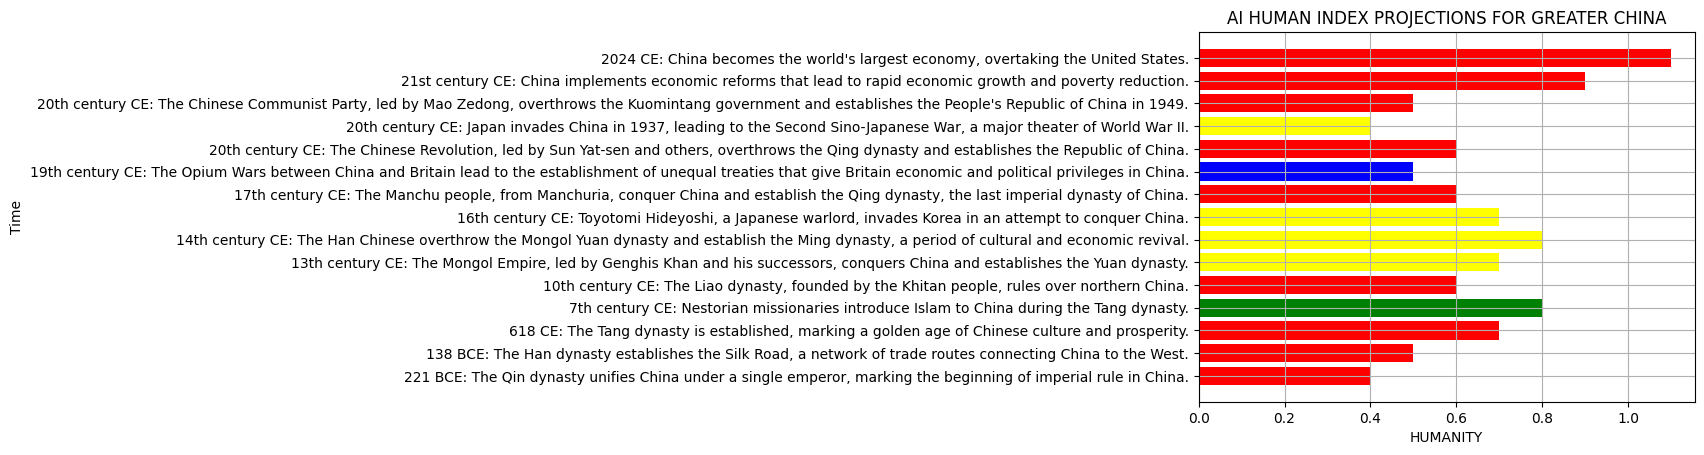

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Raw str of input
raw_str = """
221 BCE	Unification of China under the Qin dynasty	The Qin dynasty unifies China under a single emperor, marking the beginning of imperial rule in China.	0.4
138 BCE	Han dynasty establishes the Silk Road	The Han dynasty establishes the Silk Road, a network of trade routes connecting China to the West.	0.5
618 CE	Establishment of the Tang dynasty	The Tang dynasty is established, marking a golden age of Chinese culture and prosperity.	0.7
7th century CE	Introduction of Islam to China	Nestorian missionaries introduce Islam to China during the Tang dynasty.	0.8
10th century CE	Establishment of the Liao dynasty	The Liao dynasty, founded by the Khitan people, rules over northern China.	0.6
13th century CE	Mongol conquest of China	The Mongol Empire, led by Genghis Khan and his successors, conquers China and establishes the Yuan dynasty.	0.7
14th century CE	Establishment of the Ming dynasty	The Han Chinese overthrow the Mongol Yuan dynasty and establish the Ming dynasty, a period of cultural and economic revival.	0.8
16th century CE	Japanese invasion of Korea	Toyotomi Hideyoshi, a Japanese warlord, invades Korea in an attempt to conquer China.	0.7
17th century CE	Qing dynasty conquest of China	The Manchu people, from Manchuria, conquer China and establish the Qing dynasty, the last imperial dynasty of China.	0.6
19th century CE	Opium Wars	The Opium Wars between China and Britain lead to the establishment of unequal treaties that give Britain economic and political privileges in China.	0.5
20th century CE	Chinese Revolution	The Chinese Revolution, led by Sun Yat-sen and others, overthrows the Qing dynasty and establishes the Republic of China.	0.6
20th century CE	Japanese invasion of China	Japan invades China in 1937, leading to the Second Sino-Japanese War, a major theater of World War II.	0.4
20th century CE	Establishment of the People's Republic of China	The Chinese Communist Party, led by Mao Zedong, overthrows the Kuomintang government and establishes the People's Republic of China in 1949.	0.5
21st century CE	Economic reforms	China implements economic reforms that lead to rapid economic growth and poverty reduction.	0.9
2024 CE	China becomes the world's largest economy	China becomes the world's largest economy, overtaking the United States.	1.1
"""

def convert_raw_to_list(raw_str):
    # Split the raw string into lines
    lines = raw_str.strip().split("\n")
    
    # Initialize an empty list to store the events
    events_list = []
    
    # For each line in the lines
    for line in lines:
        # Split the line into components
        components = line.split("\t")
        
        # If there are four components (date, event name, description, standard of living)
        if len(components) == 4:
            # Convert the standard of living to a float
            components[3] = float(components[3])
            
            # Add the components as a tuple to the events list
            events_list.append(tuple(components))
    
    return events_list

events_list = convert_raw_to_list(raw_str)



def human_KARDASHEV_primer_plot(events_list, title = "HUMAN INDEX FOR GREATER CHINA", y_label = "HUMANITY"):
    # Initialize a list to store the times and events
    times = []
    events = []
    colors = []

    # For each event and IQ level
    for i,event in enumerate(events_list):
        # Pause for a random interval between 0.1s to 0.75s
        plt.pause(np.random.uniform(0.5, 1))

        event_name = event[1]
        event_desc = event[2]
        event_value = event[3]
        dt_str = event[0] +": " + event_desc
        # Add the current time and event to the lists
        times.append(dt_str)
        events.append(event_value)
        
        # Check the event description and assign a color accordingly
        # print(event_desc)
        if 'Islam' in event_desc:
            colors.append('green')
        elif 'Opium' in event_desc:
            colors.append('blue')
        elif 'british' in event_desc:
            colors.append('blue')
        elif 'Mongol' in event_desc:
            colors.append('yellow')
        elif 'Japan' in event_desc:
            colors.append('yellow')
        elif 'China' in event_desc:
            colors.append('red')
        else:
            colors.append('red')  # default color
        
        # Clear the current output
        clear_output(wait=True)
        
        # Create a figure and axis
        fig, ax = plt.subplots()
        
        # Plot the current time and event as a horizontal bar plot
        ax.barh(times, events, color=colors)
        
        # Set the title and labels
        ax.set_title(title)
        ax.set_xlabel(y_label)
        ax.set_ylabel('Time')
        
        # Add a grid
        ax.grid(True)
        
        # Show the plot
        plt.show()




# Git Copilot OPPA! NIHAO! help write great function to plot ASIAN PROGRESS
human_KARDASHEV_primer_plot(events_list, title = "AI HUMAN INDEX PROJECTIONS FOR GREATER CHINA", y_label = "HUMANITY")


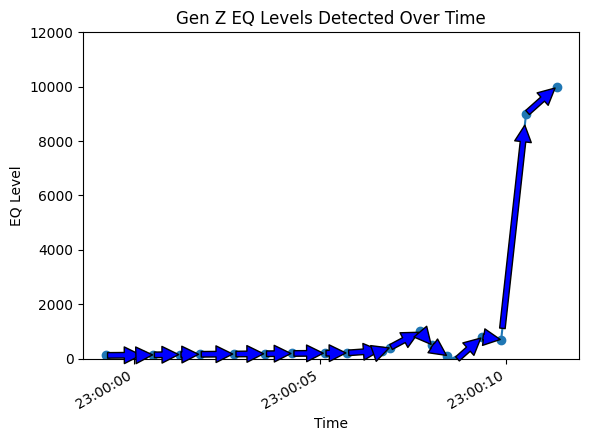

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime

# List of IQ levels
iq_list= [120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 300,400, 1000, 500, 100, -50, 800,700, 9000,10000]

# Initialize a list to store the times
times = []
window = 5

# Initialize the current time
current_time = datetime.datetime.now()

# For each IQ level
for i in iq_list:
    # Pause for a random interval between 0.2s to 1s
    pause_time = np.random.uniform(0.2, 1)
    plt.pause(pause_time)
    
    # Update the current time
    current_time += datetime.timedelta(seconds=pause_time)
    
    # Add the current time to the list of times
    times.append(current_time)
    
    # Clear the current output
    clear_output(wait=True)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot the current time and IQ level
    ax.plot(times, iq_list[:len(times)], 'o-')
    
    # Add arrows at each point
    for j in range(1, len(times)):
        ax.annotate('', xy=(times[j], iq_list[j]), xytext=(times[j-1], iq_list[j-1]),
                    arrowprops=dict(facecolor='blue', shrink=0.05))
    
    # Set the title and labels
    ax.set_title('Gen Z EQ Levels Detected Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('EQ Level')
    
    # Set the limits of the y-axis to a fixed range
    try:
        ax.set_ylim(0, max(iq_list[:len(times)])*1.2)
    except Exception as e:
        ax.set_ylim(0, max(iq_list[-window:]))

    # Format the x-axis to display dates
    fig.autofmt_xdate()

    # Show the plot
    plt.show()

# Chill fam, this  AI doing all our work here. we gucci fam.
